In [1]:
from pyspark.sql import SparkSession

try:
    spark.stop()
    print("Old Spark session stopped.")
except Exception:
    print("No active Spark session — starting fresh.")

from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

# Hard-coded safe settings for your SLURM job: 128 GB, 24 cores
SPARK_CORES = 12          
DRIVER_MEM  = "64g"      
SHUFFLE_PARTS = 320      

try:
    spark.stop()
except:
    pass

spark = (
    SparkSession.builder
        .appName("amex-spark")
        .master(f"local[{SPARK_CORES}]")
        .config("spark.driver.memory", DRIVER_MEM)
        .config("spark.sql.shuffle.partitions", str(SHUFFLE_PARTS))
        .config("spark.driver.maxResultSize", "4g")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .getOrCreate()
)

spark



No active Spark session — starting fresh.


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 12:03:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql import functions as F

ROOT = ""
clean_path = ROOT + "DKHousingPrices.parquet"

# Magic fix for old Spark + new Parquet timestamps
spark.conf.set("spark.sql.legacy.parquet.nanosAsLong", "true")
spark.conf.set("spark.sql.legacy.parquet.int96RebaseMode", "CORRECTED")

# print("Reading parquet with legacy nanos fix...")


df = spark.read.parquet("DKHousingPrices.parquet")

# ONE MAGIC LINE THAT FIXES EVERYTHING FOREVER
df = df \
    .withColumn("date", 
                F.to_date( F.from_unixtime( F.col("date") / 1_000_000_000 ) )   # nanoseconds → seconds → date
               ) \
    .withColumn("year",  F.year("date")) \
    .withColumn("month", F.month("date")) \
    .withColumn("quarter", F.concat(F.col("year"), F.lit("Q"), F.quarter("date")))

# Optional: drop the old broken quarter column if you want
df = df.drop("quarter_old").withColumnRenamed("quarter", "quarter")   # only if you still have the old one


# Continue with your pipeline
SHUFFLE_PARTS = 200
df = df.repartition(SHUFFLE_PARTS).cache()

print("Materializing cache...")
row_count = df.count()

print("="*80)
print(f"SUCCESS! {row_count:,} Danish house sales loaded and cached")
print("="*80)
df.printSchema()

Materializing cache...


SUCCESS! 1,507,908 Danish house sales loaded and cached
root
 |-- date: date (nullable = true)
 |-- quarter: string (nullable = true)
 |-- house_id: long (nullable = true)
 |-- house_type: string (nullable = true)
 |-- sales_type: string (nullable = true)
 |-- year_build: short (nullable = true)
 |-- purchase_price: integer (nullable = true)
 |-- %_change_between_offer_and_purchase: float (nullable = true)
 |-- no_rooms: byte (nullable = true)
 |-- sqm: float (nullable = true)
 |-- sqm_price: float (nullable = true)
 |-- address: string (nullable = true)
 |-- zip_code: short (nullable = true)
 |-- city: string (nullable = true)
 |-- area: string (nullable = true)
 |-- region: string (nullable = true)
 |-- nom_interest_rate%: float (nullable = true)
 |-- dk_ann_infl_rate%: float (nullable = true)
 |-- yield_on_mortgage_credit_bonds%: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [8]:
# Proof it works
df.select("date", "year", "quarter", "house_type", "purchase_price", "sqm") \
  .orderBy(F.desc("date")) \
  .show(5, truncate=False)

# Proof it works
df.select("date", "year", "quarter", "house_type", "purchase_price", "sqm") \
  .orderBy(F.asc("date")) \
  .show(5, truncate=False)  

+----------+----+-------+-----------+--------------+-----+
|date      |year|quarter|house_type |purchase_price|sqm  |
+----------+----+-------+-----------+--------------+-----+
|2024-10-25|2024|2024Q4 |Farm       |6600000       |180.0|
|2024-10-25|2024|2024Q4 |Summerhouse|450000        |36.0 |
|2024-10-25|2024|2024Q4 |Villa      |4350000       |215.0|
|2024-10-24|2024|2024Q4 |Villa      |3375000       |176.0|
|2024-10-24|2024|2024Q4 |Apartment  |1495000       |64.0 |
+----------+----+-------+-----------+--------------+-----+
only showing top 5 rows
+----------+----+-------+-----------+--------------+-----+
|date      |year|quarter|house_type |purchase_price|sqm  |
+----------+----+-------+-----------+--------------+-----+
|1992-01-04|1992|1992Q1 |Summerhouse|525000        |67.0 |
|1992-01-04|1992|1992Q1 |Villa      |750000        |252.0|
|1992-01-04|1992|1992Q1 |Farm       |917316        |203.0|
|1992-01-04|1992|1992Q1 |Townhouse  |475000        |74.0 |
|1992-01-04|1992|1992Q1 |Villa  

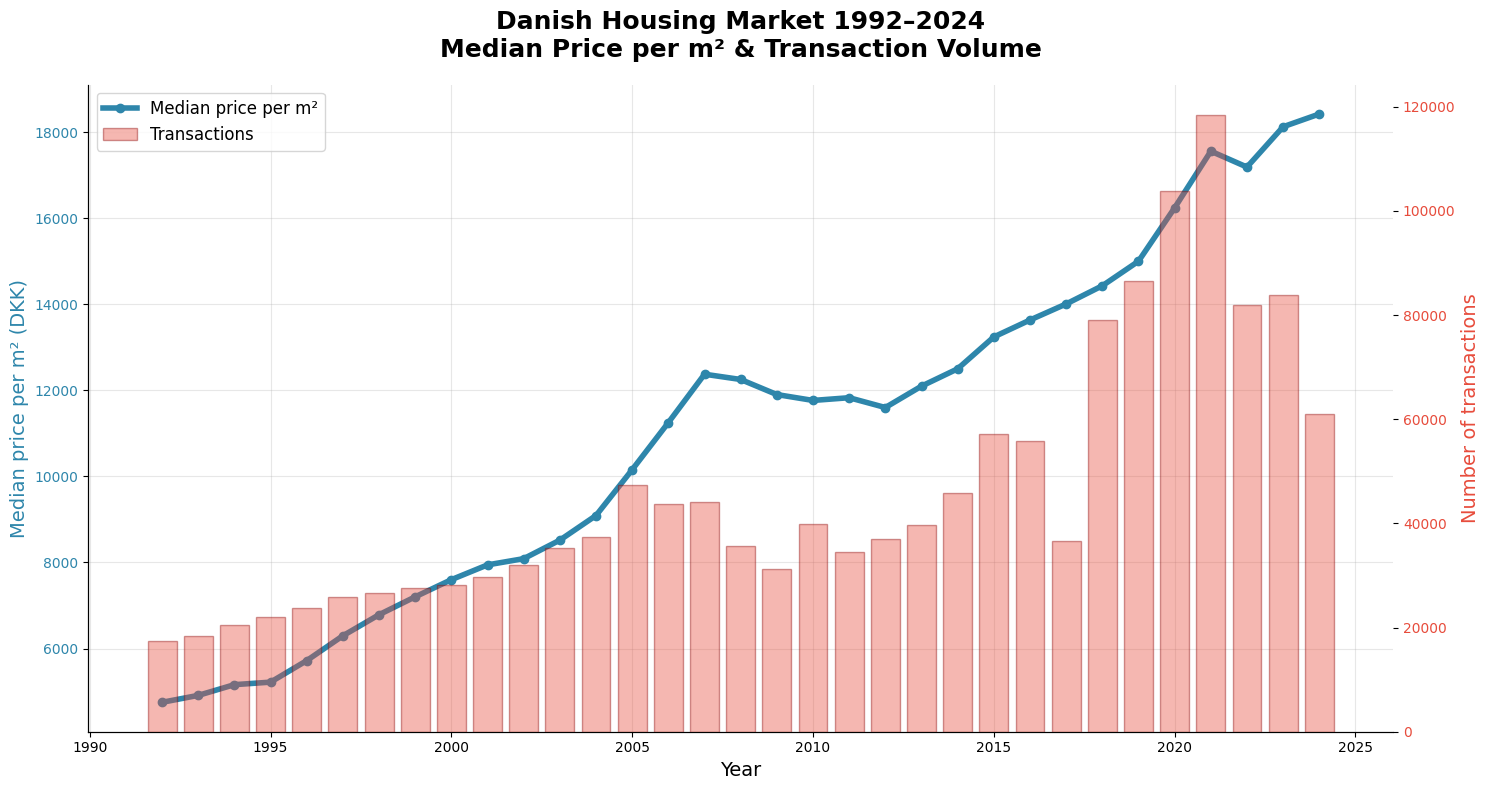

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = (df
           .groupBy("year")
           .agg(F.percentile_approx("sqm_price", 0.5).alias("median_sqm_price"),
                F.count("*").alias("transactions"))
           .orderBy("year")
           .toPandas())

fig, ax1 = plt.subplots(figsize=(15, 8))

# Median price per m² (left axis)
ax1.plot(df_plot["year"], df_plot["median_sqm_price"],
         color="#2e86ab", linewidth=4, marker="o", markersize=6, label="Median price per m²")
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Median price per m² (DKK)", color="#2e86ab", fontsize=14)
ax1.tick_params(axis="y", labelcolor="#2e86ab")
ax1.grid(True, alpha=0.3)

# Transaction volume (right axis) ← FIXED HERE
ax2 = ax1.twinx()
ax2.bar(df_plot["year"], df_plot["transactions"],
        alpha=0.4, color="#e74c3c", edgecolor="darkred", label="Transactions")
ax2.set_ylabel("Number of transactions", color="#e74c3c", fontsize=14)
ax2.tick_params(axis="y", labelcolor="#e74c3c")

# Title and legend
plt.title("Danish Housing Market 1992–2024\nMedian Price per m² & Transaction Volume",
          fontsize=18, fontweight="bold", pad=20)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

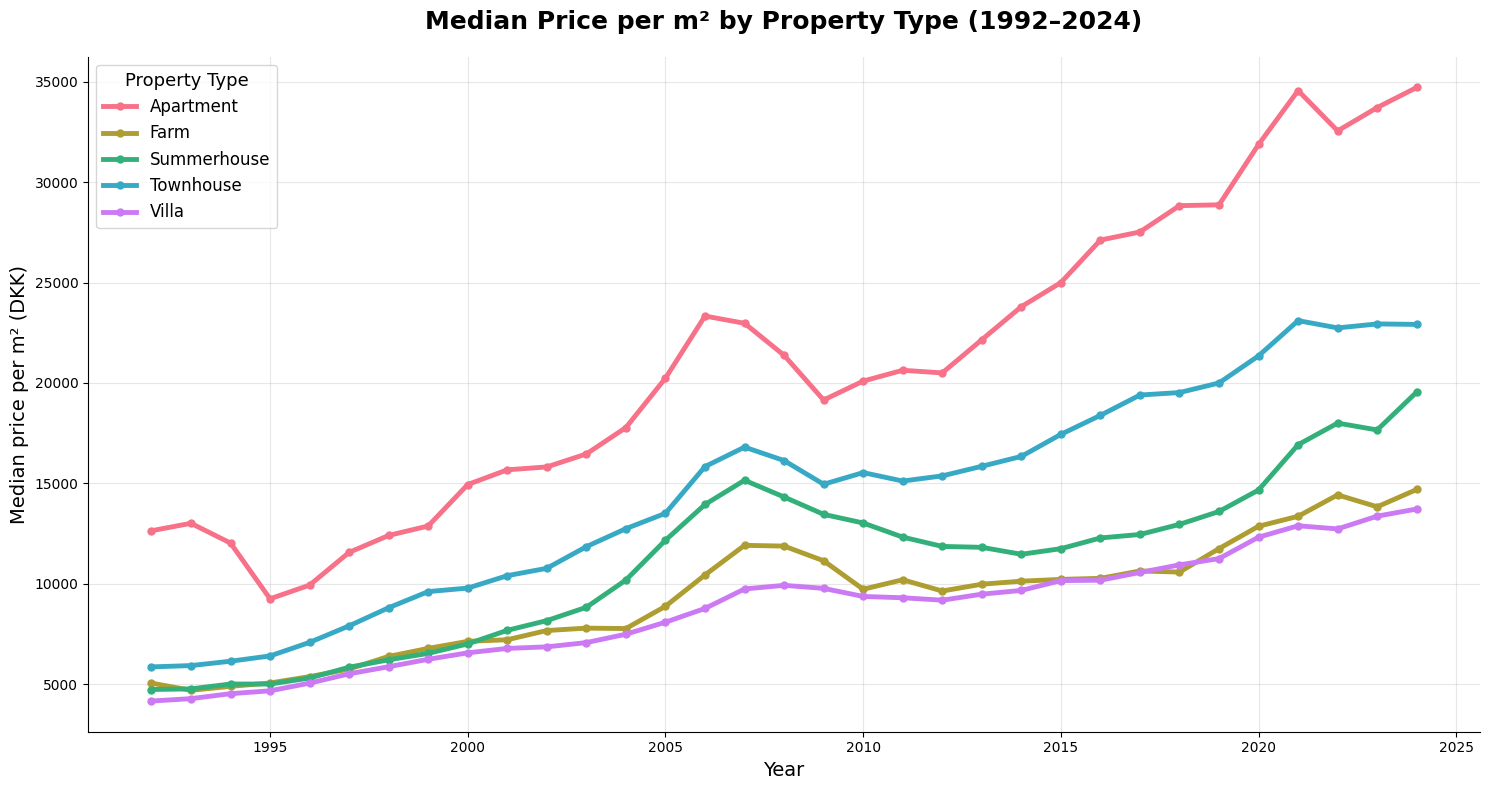

In [14]:
# Price evolution by property type
df_type = (df.groupBy("year", "house_type")
           .agg(F.percentile_approx("sqm_price", 0.5).alias("median_sqm_price"))
           .orderBy("year", "house_type")
           .toPandas())

plt.figure(figsize=(15, 8))
palette = sns.color_palette("husl", 5)

for i, htype in enumerate(df_type["house_type"].unique()):
    data = df_type[df_type["house_type"] == htype]
    plt.plot(data["year"], data["median_sqm_price"],
             marker="o", linewidth=3.5, label=htype, color=palette[i], markersize=5)

plt.title("Median Price per m² by Property Type (1992–2024)", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Median price per m² (DKK)", fontsize=14)
plt.legend(title="Property Type", fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

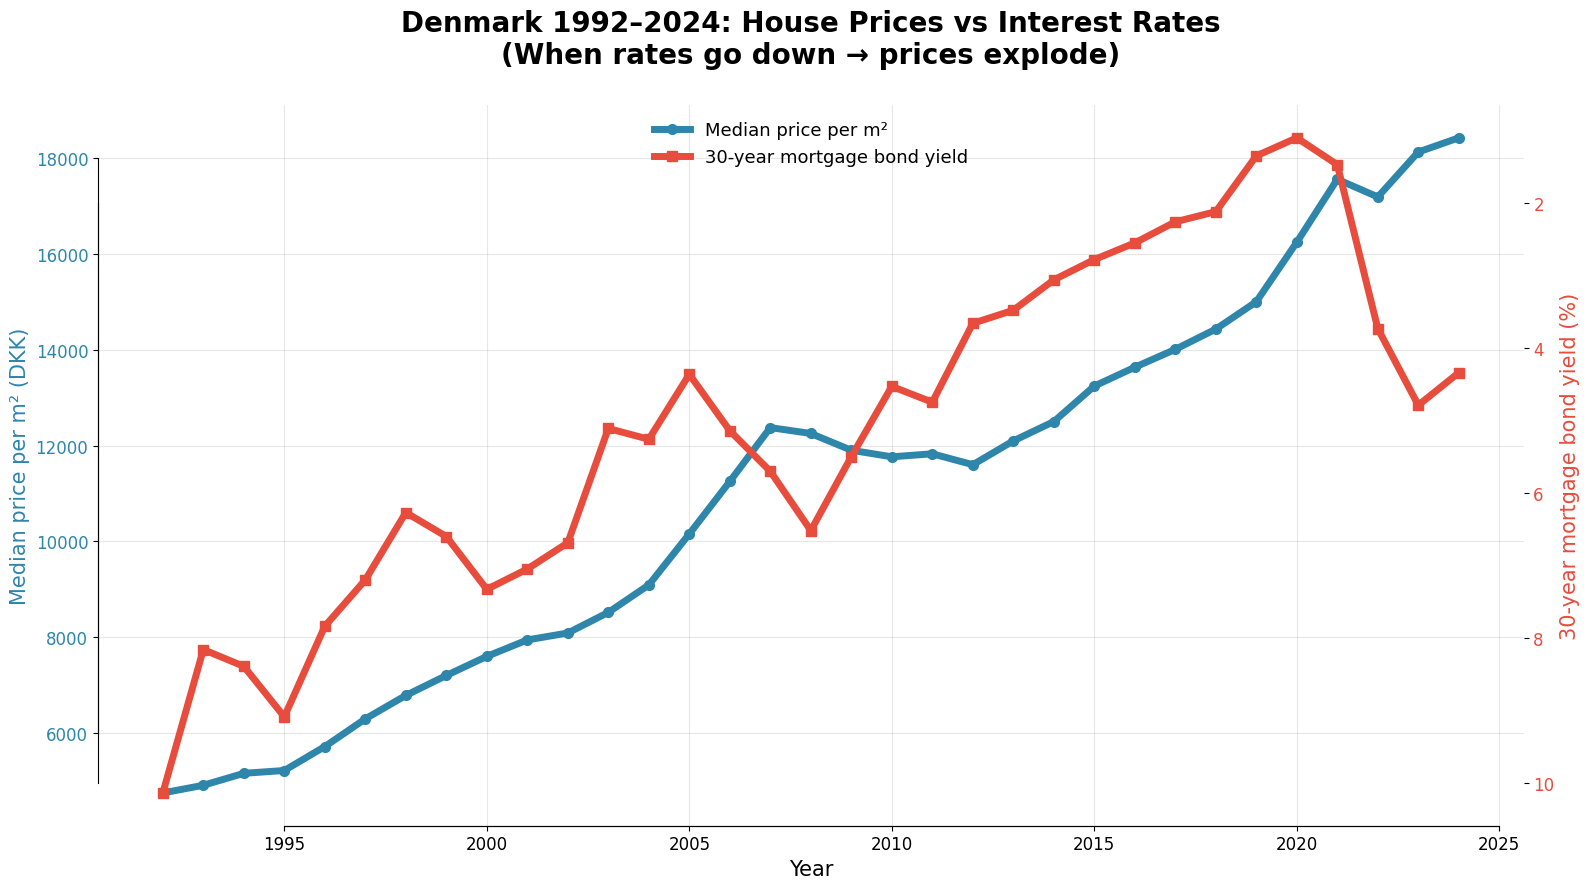

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Calculate yearly median price + average 30-year mortgage bond yield
df_macro = (df.groupBy("year")
            .agg(F.percentile_approx("sqm_price", 0.5).alias("median_sqm_price"),
                 F.mean("yield_on_mortgage_credit_bonds%").alias("mortgage_rate"))
            .orderBy("year")
            .toPandas())

# Plot
fig, ax1 = plt.subplots(figsize=(16, 9))

# Price per m² — left axis
color1 = "#2e86ab"
ax1.plot(df_macro["year"], df_macro["median_sqm_price"],
         color=color1, linewidth=5, marker="o", markersize=7, label="Median price per m²")
ax1.set_xlabel("Year", fontsize=15)
ax1.set_ylabel("Median price per m² (DKK)", color=color1, fontsize=15)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, alpha=0.3)

# Mortgage rate — right axis (inverted so low rate = high price looks natural)
ax2 = ax1.twinx()
color2 = "#e74c3c"
ax2.plot(df_macro["year"], df_macro["mortgage_rate"],
         color=color2, linewidth=5, marker="s", markersize=7, label="30-year mortgage bond yield")
ax2.set_ylabel("30-year mortgage bond yield (%)", color=color2, fontsize=15)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)
ax2.invert_yaxis()   # THIS makes the relationship crystal clear

# Title & legend
plt.title("Denmark 1992–2024: House Prices vs Interest Rates\n"
          "(When rates go down → prices explode)", 
          fontsize=20, fontweight="bold", pad=30)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=13, frameon=False)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

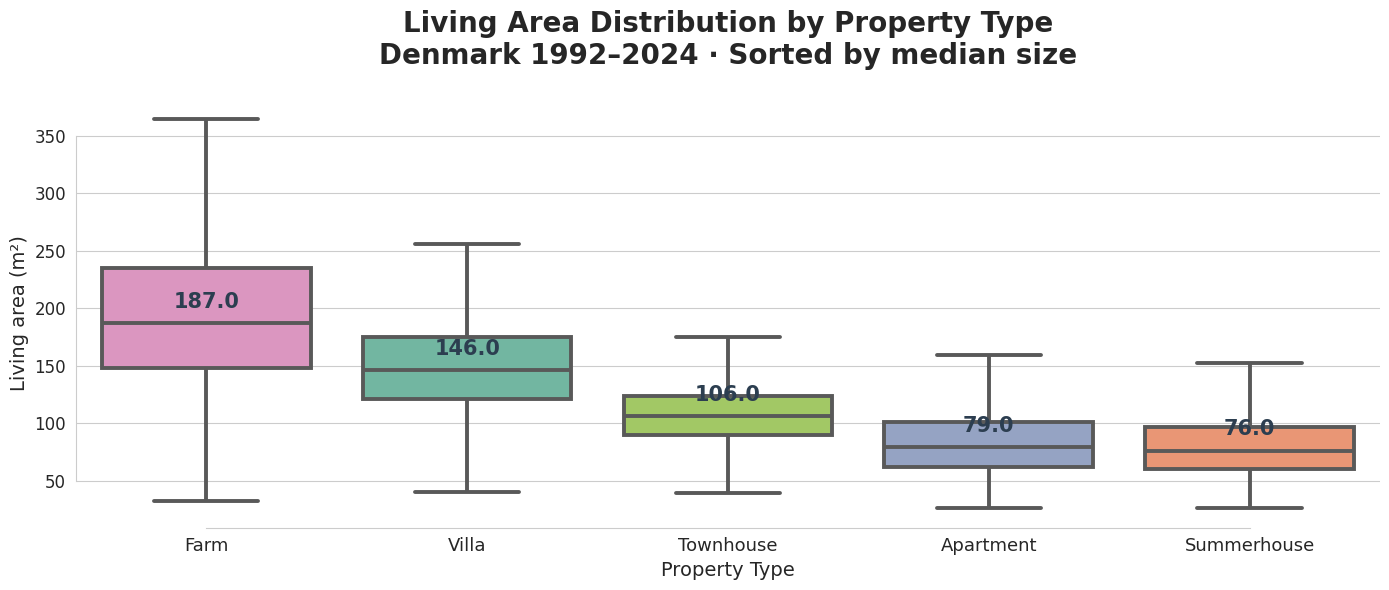

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Get data + calculate correct order by median size
df_size = df.select("house_type", "sqm").toPandas()   # ~1.5M rows is fine on modern laptops

# Compute median per type and sort descending
median_order = (df_size.groupby("house_type")["sqm"]
                     .median()
                     .sort_values(ascending=False)
                     .index
                     .tolist())


# 2. Plot — clean, no warnings, no outliers
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

sns.boxplot(data=df_size,
            x="house_type",
            y="sqm",
            order=median_order,
            hue="house_type",          # this removes the FutureWarning
            palette="Set2",
            linewidth=2.8,
            showfliers=False,          # no outlier dots
            legend=False)              # we don't need legend when x = hue

# 3. Add median labels on top
medians = df_size.groupby("house_type")["sqm"].median().reindex(median_order).round(1)
for i, med in enumerate(medians):
    plt.text(i, med + 10, f"{med}", 
             ha='center', va='bottom', fontsize=15, fontweight='bold', color="#2c3e50")

# 4. Polish
plt.title("Living Area Distribution by Property Type\nDenmark 1992–2024 ⋅ Sorted by median size", 
          fontsize=20, fontweight="bold", pad=25)
plt.xlabel("Property Type", fontsize=14)
plt.ylabel("Living area (m²)", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

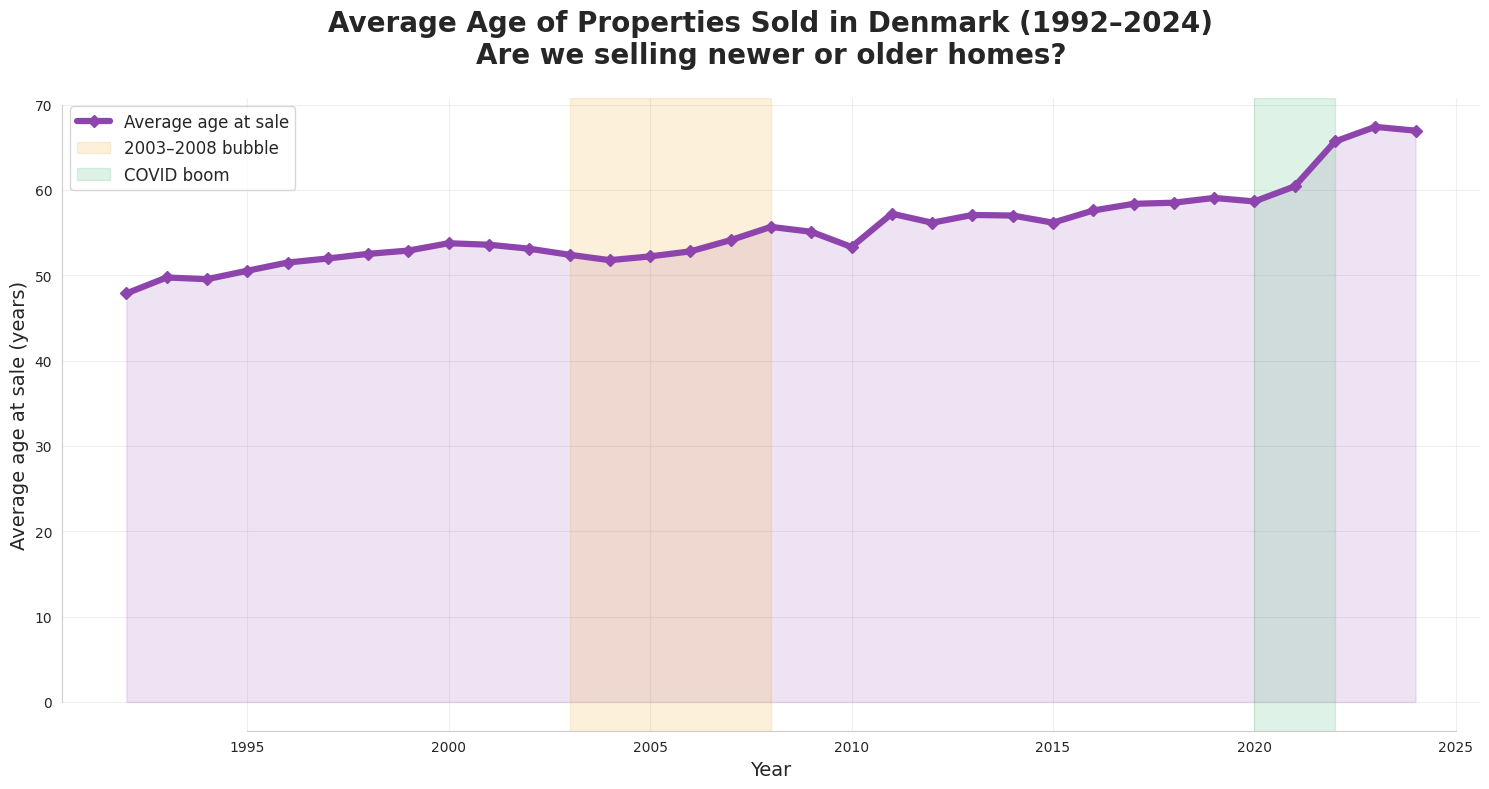

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Calculate age at sale and average per year
df_age = (df
          .withColumn("age_at_sale", F.col("year") - F.col("year_build"))
          .groupBy("year")
          .agg(F.mean("age_at_sale").alias("avg_age_years"))
          .orderBy("year")
          .toPandas())

# Plot
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

plt.plot(df_age["year"], df_age["avg_age_years"],
         color="#8e44ad", linewidth=4.5, marker="D", markersize=6, label="Average age at sale")

plt.fill_between(df_age["year"], df_age["avg_age_years"], 
                 color="#8e44ad", alpha=0.15)

plt.title("Average Age of Properties Sold in Denmark (1992–2024)\n"
          "Are we selling newer or older homes?", 
          fontsize=20, fontweight="bold", pad=25)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Average age at sale (years)", fontsize=14)

# Highlight key periods
plt.axvspan(2003, 2008, color="#f39c12", alpha=0.15, label="2003–2008 bubble")
plt.axvspan(2020, 2022, color="#27ae60", alpha=0.15, label="COVID boom")
# plt.yticks(ticks=[410, 50, 60, 70])

plt.legend(fontsize=12, loc="upper left")
plt.grid(True, alpha=0.3)
sns.despine(trim=True)
plt.tight_layout()
plt.show()

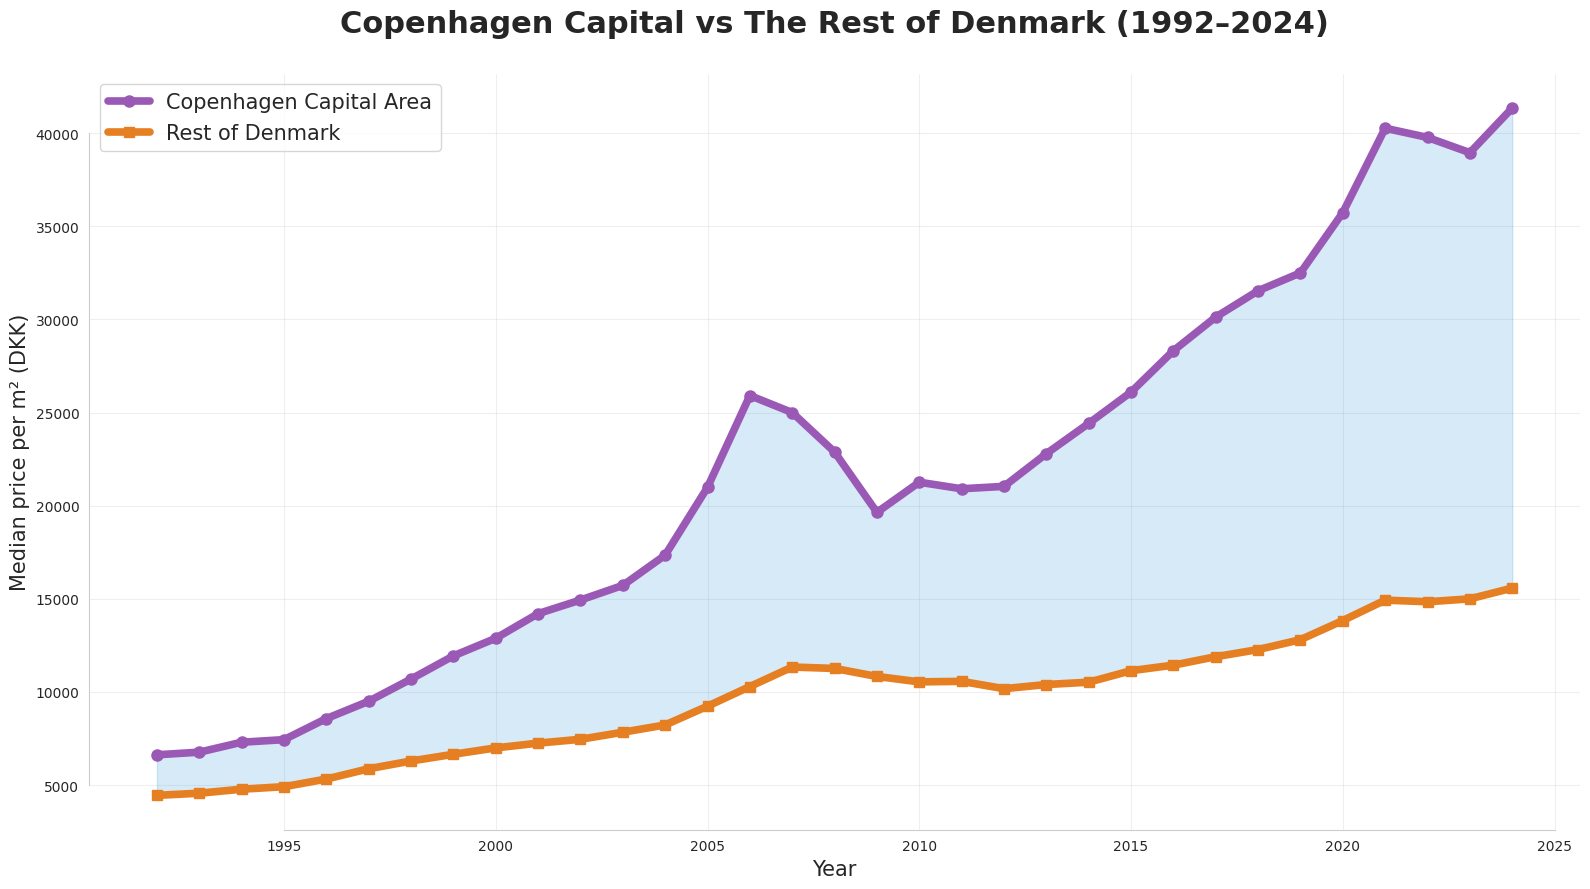

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Create Copenhagen vs Rest of Denmark
df_cph = (df
          .withColumn("region_group",
                      F.when(F.col("area") == "Capital, Copenhagen", "Copenhagen Capital")
                       .otherwise("Rest of Denmark"))
          .groupBy("year", "region_group")
          .agg(F.percentile_approx("sqm_price", 0.5).alias("median_sqm_price"))
          .orderBy("year")
          .toPandas())

# 2. Pivot
pivot = df_cph.pivot(index="year", columns="region_group", values="median_sqm_price").reset_index()

# 3. Plot — now with correct hex colors!
plt.figure(figsize=(16, 9))
sns.set_style("whitegrid")

# Copenhagen in deep purple
plt.plot(pivot["year"], pivot["Copenhagen Capital"],
         color="#9b59b6", linewidth=5.5, marker="o", markersize=8,
         label="Copenhagen Capital Area")

# Rest of Denmark in warm orange
plt.plot(pivot["year"], pivot["Rest of Denmark"],
         color="#e67e22", linewidth=5.5, marker="s", markersize=7,
         label="Rest of Denmark")

# Fill the gap
plt.fill_between(pivot["year"],
                 pivot["Copenhagen Capital"],
                 pivot["Rest of Denmark"],
                 color="#3498db", alpha=0.2)

# 2024 ratio annotation
ratio_2024 = pivot.loc[pivot["year"] == 2024, "Copenhagen Capital"].values[0] / \
             pivot.loc[pivot["year"] == 2024, "Rest of Denmark"].values[0]

plt.title("Copenhagen Capital vs The Rest of Denmark (1992–2024)",
          fontsize=22, fontweight="bold", pad=30)

plt.xlabel("Year", fontsize=15)
plt.ylabel("Median price per m² (DKK)", fontsize=15)
plt.legend(fontsize=15, loc="upper left")
plt.grid(True, alpha=0.3)
sns.despine(trim=True)
plt.tight_layout()
plt.show()